In [ ]:
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import os

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/handwrittengeneration/english.csv')
img_height, img_width = 28, 28
image_dir = '/content/drive/MyDrive/handwrittengeneration'  # Root directory
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)
def load_images(df):
    images = []
    labels = []
    missing = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            missing.append(img_path)
            continue
        try:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0
            images.append(img)
            labels.append(row['label_encoded'])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    if missing:
        print(f"\n⚠️ Skipped {len(missing)} missing/unreadable images.")
    return np.array(images), to_categorical(labels, num_classes)


X, y = load_images(df)
X = X.reshape(-1, img_height, img_width, 1)
print(f"\n✅ Loaded {X.shape[0]} images. Shape: {X.shape}, Labels: {y.shape}")



✅ Loaded 3410 images. Shape: (3410, 28, 28, 1), Labels: (3410, 62)


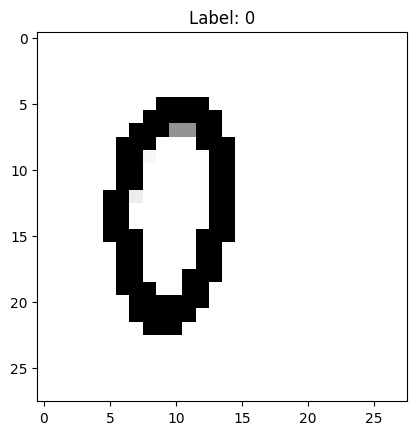

In [ ]:
plt.imshow(X[0].reshape(img_height, img_width), cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([np.argmax(y[0])])[0]}")
plt.show()


<Axes: xlabel='label_encoded', ylabel='count'>

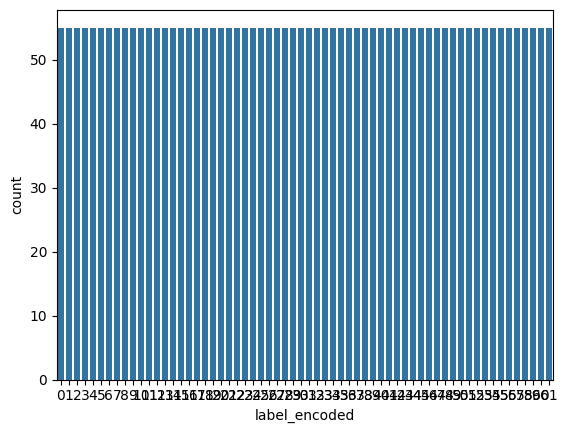

In [ ]:
sns.countplot(x=df['label_encoded'])


In [ ]:
def create_sequences(X, y, seq_len):
    sequences = []
    targets = []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        targets.append(y[i+seq_len])
    return np.array(sequences), np.array(targets)

sequence_length = 10
X_seq, y_seq = create_sequences(X, y, sequence_length)
print(f"\n📐 Sequence shape: {X_seq.shape}, Target shape: {y_seq.shape}")



📐 Sequence shape: (3400, 10, 28, 28, 1), Target shape: (3400, 62)


In [ ]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length, img_height, img_width, 1)),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 26, 26, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 13, 13, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 5408)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     2,834,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,843,262 (10.85 MB)

 Trainable params: 2,843,262 (10.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_seq, y_seq, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 690ms/step - accuracy: 0.0753 - loss: 3.9641 - val_accuracy: 0.0059 - val_loss: 6.1504
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 649ms/step - accuracy: 0.8063 - loss: 1.1338 - val_accuracy: 0.0294 - val_loss: 7.7980
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 651ms/step - accuracy: 0.9700 - loss: 0.2611 - val_accuracy: 0.0206 - val_loss: 7.9897
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 643ms/step - accuracy: 0.9813 - loss: 0.1133 - val_accuracy: 0.0294 - val_loss: 8.5139
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 651ms/step - accuracy: 0.9889 - loss: 0.0702 - val_accuracy: 0.0206 - val_loss: 8.3149
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 641ms/step - accuracy: 0.9908 - loss: 0.0539 - val_accuracy: 0.0265 - val_loss: 8.9654
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 642ms/step - accuracy: 0.9942 - loss: 0.0356 - val_accuracy: 0.0265 - val_loss: 9.2682
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 648ms/step - accuracy: 0.9932 - loss: 0.0399 - val_accu

In [ ]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    probs = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(probs), p=probs)

def generate_sequence(model, seed_sequence, label_encoder, length=20, temperature=1.0):
    generated_labels = []
    current_sequence = seed_sequence.copy()

    for _ in range(length):
        # Predict next character
        preds = model.predict(current_sequence[np.newaxis, ...])[0]
        next_index = sample_with_temperature(preds, temperature)
        next_label = label_encoder.inverse_transform([next_index])[0]
        generated_labels.append(next_label)


        next_image = current_sequence[-1]
        current_sequence = np.concatenate([current_sequence[1:], next_image[np.newaxis, ...]], axis=0)

    return generated_labels


In [ ]:
seed = X_seq[100]
generated = generate_sequence(model, seed, label_encoder, length=20, temperature=0.8)
print("📝 Generated sequence:", ''.join(generated))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📝 Generated sequence: 2222I22III11I1I21II2


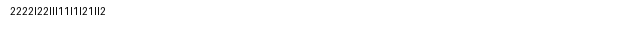

In [ ]:
from IPython.display import display

def render_text(text, font_size=32):
    img = Image.new('RGB', (len(text)*font_size, font_size+20), color='white')
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    draw.text((10, 5), text, font=font, fill='black')
    display(img)  # Show image inline

render_text(''.join(generated))
